# Linear Regression

Linear regression algorithm is the most interpretable Machine Learning algorithm available for analyzing linear relationships between features and target variables.

Equation of Linear Regression:

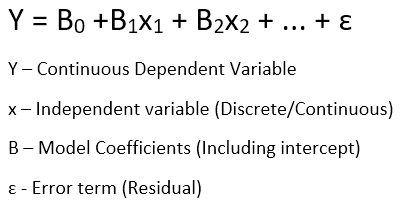

Main objective of linear regression is to identify the best fit regression line that minimizes error term, ɛ.

Model coefficients for <b>simple linear regression</b> are estimated using ordinary least squares (OLS) method by minimizing the sum of squared residuals as follows:

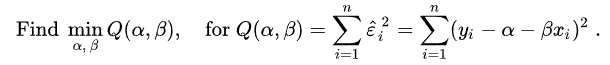

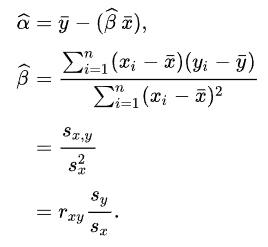

For <b>multiple linear regression</b>, gradient descent algorithm (continuous learning until threshold is reached) is used for estimating model coefficients as follows:

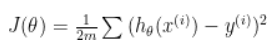

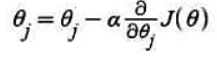

<img src="https://raw.githubusercontent.com/satishgunjal/Images/master/gradient_descent_formula_n_features.PNG" width="400">

<img src ="https://www.statology.org/wp-content/uploads/2020/12/residuals2.png" width="500">

One main drawback of gradient descent algorithm is the value of cost function may not be able to converge to local minima due to existence of plateaus or very high learning rate.

Methods to overcome failure to converge to local minima point:
1. Feature Selection
2. Learning rate scheduling (varying learning rate)
3. Changing initialization method
4. Using advance optimization methods

<b>Note that more details about gradient descent algorithm will be covered in Deep Learning modules</b>.

<b>Assumptions of Linear Regression</b>:
1. Linear in terms of coefficient and residuals
2. Zero correlation between residuals
3. Exogeneity: Features are uncorrelated with residuals
4. Homoscedasticity: Residuals have constant variance
5. No multicollinearity: Features are uncorrelated with one another
6. Residuals are normally distributed with zero mean

<b>Requirement of feature scaling: Yes</b>

<b>Robust to outliers: No</b>

<b>Is multicollinearity an issue?: Yes</b>

<b>Advantages of Linear Regression:</b>
1. Model coefficients easy to interpret
2. Suitable to use for datasets with linear relationships
3. Model can be regularized to prevent model overfitting

<b>Disadvantages of Linear Regression:</b>
1. Model performance may be impacted by outliers
2. Model may be too simplistic, which may not be able to capture complex relationships between variables

<b>Time complexity of model training: O(np^2 + p^3)</b>

<b>Time complexity of model prediction: O(p)</b>

<b>Space complexity of model prediction: O(p)</b>

- n - Number of training samples

- p - Number of features

In [1]:
# Import all required Python libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from skopt import BayesSearchCV
from sklearn.linear_model import Lasso, LinearRegression, HuberRegressor, Ridge, ElasticNet
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan, acorr_breusch_godfrey, normal_ad
from transformers import OutlierCapTransformer, GaussianTransformer, ScalingTransformer

More details related to Exploratory Data Analysis for this regression problem statement can be found in the following Jupyter Notebook within the same folder: EDA_Regression.ipynb

In [2]:
data = fetch_california_housing()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Median House Value ($100000)'

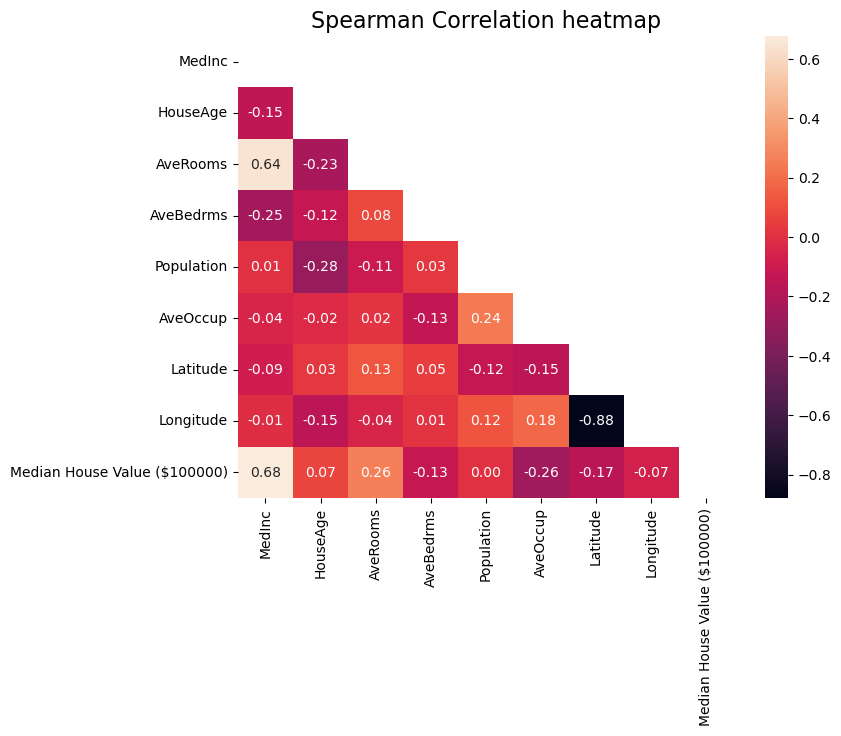

In [3]:
combined_data = pd.concat([X,y],axis=1)
correlation = combined_data.corr(method='spearman')
plt.figure(figsize=(8,6))
sns.heatmap(
    correlation, annot=True, mask = np.triu(np.ones_like(correlation, dtype=bool)),fmt='.2f',annot_kws={'fontsize':10})
plt.title('Spearman Correlation heatmap',size=16)
plt.show()

From the correlation heatmap above, there is a very strong correlation between latitude and longitude according to spearman correlation method. Either longitude and latitude variable can be removed from the dataset to avoid multicollinearity problem.

Note that correlation heatmaps only identify bivariate relationships. A better alternative to detect multicollinearity is using Variance Inflation Factor (VIF)

In [4]:
max_vif = np.inf
X_sub = X.copy()
while max_vif > 5:
    vif = [variance_inflation_factor(X_sub.select_dtypes('float').values, i) for i in range(X_sub.select_dtypes('float').shape[1])]
    max_vif = np.max(vif)
    if max_vif > 5:
        column = pd.DataFrame({'vif': vif}, index=X_sub.select_dtypes('float').columns).idxmax().values[0]
        X_sub.drop([column],axis=1,inplace=True)
        print(column, 'column is removed with vif value of',max_vif)

Longitude column is removed with vif value of 633.7116543669108
AveRooms column is removed with vif value of 42.19222281556557
Latitude column is removed with vif value of 21.92251505242187


In [5]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = KFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_rmse, test_rmse = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        if search_space != None:
            search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,
                                   scoring= make_scorer(mean_squared_error, squared=False),refit=True, n_jobs=3)
            search.fit(X_train,y_train)
            val_rmse.append(search.best_score_)
            print(f'Validation RMSE for fold {fold+1}:',search.best_score_)
            print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
            y_pred = search.best_estimator_.predict(X_test)
        else:
            cv_results = cross_validate(pipeline, X_train, y_train, scoring = {'rmse': make_scorer(mean_squared_error, squared=False)}, cv=3, n_jobs=3)
            val_rmse.append(cv_results['test_rmse'].mean())
            print(f'Validation RMSE for fold {fold+1}:', cv_results['test_rmse'].mean())
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
        test_rmse.append(mean_squared_error(y_test,y_pred,squared=False))
        print(f'Test RMSE for fold {fold+1}:',mean_squared_error(y_test,y_pred,squared=False))
    print('----------------------')
    print('Average validation RMSE score:', np.mean(val_rmse))
    print('Average test RMSE score:', np.mean(test_rmse))

In [6]:
reg = LinearRegression()
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X_sub.columns.tolist())])
pipeline.steps.append(['gaussian_transform',GaussianTransformer(X_sub.columns.tolist())])
pipeline.steps.append(('scaling',ScalingTransformer('Robust')))
pipeline.steps.append(('regression',reg))
nested_cv(X_sub, y, pipeline)

Validation RMSE for fold 1: 0.756135892963183
Test RMSE for fold 1: 0.7255073819926751
Validation RMSE for fold 2: 0.7556670545956016
Test RMSE for fold 2: 0.7499630863542924
Validation RMSE for fold 3: 0.750486247523153
Test RMSE for fold 3: 0.7793914998369864
Validation RMSE for fold 4: 0.7537514592532553
Test RMSE for fold 4: 0.7582395454075163
Validation RMSE for fold 5: 0.7551927087948576
Test RMSE for fold 5: 0.7448890496722674
Validation RMSE for fold 6: 0.7567203861352744
Test RMSE for fold 6: 0.7300257300568058
Validation RMSE for fold 7: 0.7521761557474442
Test RMSE for fold 7: 0.7643993851805785
Validation RMSE for fold 8: 0.7535787111638449
Test RMSE for fold 8: 0.7468592549288472
Validation RMSE for fold 9: 0.7562478247243494
Test RMSE for fold 9: 0.7262250139619452
Validation RMSE for fold 10: 0.7563536020560205
Test RMSE for fold 10: 0.7308202163722637
----------------------
Average validation RMSE score: 0.7546310042956985
Average test RMSE score: 0.7456320163764178


# Linear Regression Assumption Checks

## Model Linearity

Using rainbow's test from statsmodels library:

Null hypothesis: The linear specification of regression model is correct

Alternative hypothesis: The linear specification of regression model is incorrect.

In [7]:
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X_sub.columns.tolist())])
pipeline.steps.append(['gaussian_transform',GaussianTransformer(X_sub.columns.tolist())])
pipeline.steps.append(('scaling',ScalingTransformer('Robust')))

X_transformed = pipeline.fit_transform(X_sub, y)
model = OLS(y, X_transformed)
results = model.fit()
linear_test = linear_rainbow(results)
print(f'F-test statistic: {linear_test[0]}')
print(f'p-value: {linear_test[1]}')

F-test statistic: 1.0658523899689167
p-value: 0.0006005787583929192


Since p-value is less than 0.05, there is sufficient evidence to conclude that the linear specification of the regression model is incorrect. Thus, the null hypothesis is rejected.

## Homoscedasticity test

Using Breusch-Pagan test from statsmodels library:

Null hypothesis: Homoscedasticity is present (Residuals are distributed with equal variance)

Alternative hypothesis: Homoscedasticity is not present (Residuals are distributed with unequal variance)

In [8]:
test = het_breuschpagan(results.resid, results.model.exog)
print(f'F-test statistic: {test[2]}')
print(f'p-value: {test[3]}')

F-test statistic: 90.61358167247143
p-value: 1.2020515515016546e-94


Since p-value is less than 0.05, there is sufficient evidence to conclude that homoscedasticity is not present. Thus, the null hypothesis is rejected.

## Autocorrelation test

Using breusch-godfrey test:

Null hypothesis: There is zero autocorrelation between residuals

Alternative hypothesis: There is some autocorrelation between residuals

In [9]:
test = acorr_breusch_godfrey(results)
print(f'F-test statistic: {test[2]}')
print(f'p-value: {test[3]}')

F-test statistic: 729.0009211814386
p-value: 0.0


Since p-value is less than 0.05, there is sufficient evidence to conclude there is some autocorrelation between residuals. Thus, the null hypothesis is rejected.

## Multicollinearity and Exogeneity test

Using Variance Inflation Factor, VIF values should be less than 5 indicating little to no correlation between independent features (no multicollinearity) and between features and residuals (exogeneity).

In [10]:
# Using variance inflation factor
X_combined = pd.concat([X_transformed, pd.Series(results.resid, name='Residual')],axis=1)
vif = [variance_inflation_factor(X_combined.values, i) for i in range(X_combined.shape[1])]
pd.DataFrame({'vif': vif}, index=X_combined.columns).T

,MedInc,HouseAge,AveBedrms,Population,AveOccup,Residual
vif,1.085043,1.160435,1.091965,1.179667,1.088183,1.0


From the results above, all VIF values are less than 5. This indicates that there is no multicollinearity and all relationships between features and residuals are independent.

## Normality test with zero mean

Using Anderson test:

Null hypothesis: Residuals are normally distributed.

Alternative hypothesis: Residuals are not normally distributed.

In [11]:
test = normal_ad(results.resid)
print(f'F-test statistic: {test[0]}')
print(f'p-value: {test[1]}')
print(f'Mean of residuals: {np.mean(results.resid)}')

F-test statistic: 93.27539756199621
p-value: 0.0
Mean of residuals: 1.7350754142684492


Since p-value is less than 0.05, there is sufficient evidence to conclude that the residuals of the regression model are not normally distributed. Thus, the null hypothesis is rejected. In addition, the mean of residuals are not close to zero.

## Polynomial Regression

Note that all points related to Linear Regression is also applicable for Polynomial regression, except that Polynomial regression greatly increases model complexity which may be more prone to model overfitting.

In [12]:
reg = LinearRegression()
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X_sub.columns.tolist())])
pipeline.steps.append(['gaussian_transform',GaussianTransformer(X_sub.columns.tolist())])
pipeline.steps.append(('scaling',ScalingTransformer('Robust')))
pipeline.steps.append(('polynomial',PolynomialFeatures(include_bias=False)))
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['polynomial__degree'] = Integer(2,5)
nested_cv(X_sub, y, pipeline, search_space)

Validation RMSE for fold 1: 0.7252995290805848
Best hyperparameters for fold 1: OrderedDict([('polynomial__degree', 2)])
Test RMSE for fold 1: 0.6808547181222442
Validation RMSE for fold 2: 0.7229279805631986
Best hyperparameters for fold 2: OrderedDict([('polynomial__degree', 2)])
Test RMSE for fold 2: 0.6999799097751768
Validation RMSE for fold 3: 0.718321976495989
Best hyperparameters for fold 3: OrderedDict([('polynomial__degree', 2)])
Test RMSE for fold 3: 0.7398999193581353
Validation RMSE for fold 4: 0.7209709191721636
Best hyperparameters for fold 4: OrderedDict([('polynomial__degree', 2)])
Test RMSE for fold 4: 0.7169715320605365
Validation RMSE for fold 5: 0.7160988283394844
Best hyperparameters for fold 5: OrderedDict([('polynomial__degree', 3)])
Test RMSE for fold 5: 0.6723387798363875
Validation RMSE for fold 6: 0.7232350705894793
Best hyperparameters for fold 6: OrderedDict([('polynomial__degree', 2)])
Test RMSE for fold 6: 0.6854837402441816
Validation RMSE for fold 7: 0

# R-squared vs Adjusted R-squared

R-squared statistic is a measure of goodness of fit of variables on regression model.

<b>Formula of R-squared</b>:

<img src ="https://miro.medium.com/max/1200/1*_HbrAW-tMRBli6ASD5Bttw.png" width="500">

The value of R-squared is usually between 0 and 1, which indicates the closer the value of R-squared to 1, the better the regression model fits the data and vice versa.

R-squared value is mostly suitable for model evaluation on linear regression models with only <b>one feature</b>.

One major disadvantage of R-squared is that including more features in regression model will lead to higher R-squared value, which misleads the performance of regression models. Including features that are insignificant in regression models may actually worsen its performance instead (overfitting)

An alternative to overcome the issue of using R-squared statistic for model evaluation is using Adjusted R-squared statistic.

Adjusted R-squared statistic penalizes excessive use of independent features that don't correlate with target variables, which can be used as part of feature selection with wrapper methods (i.e. forward/backward selection).

<b>Formula of Adjusted R-squared</b>:

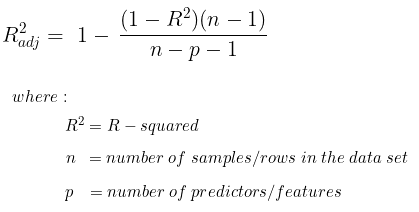

Similar to R-squared, the value of adjusted R-squared is usually between 0 and 1, which indicates the closer its value to 1, the better the regression model fits the data and vice versa.

For linear regression with multiple features, adjusted R-squared is the preferred choice for model evaluation over R-squared.

# Interpretation of regression coefficients

For regression models, coefficients in multiple linear regression models represent the relationship between given feature and target, assuming that all other features remain constant (<b>conditional dependence</b>).

Interpretation:
1. For continuous features, a unit increase in independent feature is associated with n unit increase or decrease in target value.

2. For categorical features, if target value increase or decrease by n units, it is considered as a specific category.

Note that coefficient interpretation for feature selection requires extra caution by <b>multiplying the coefficients by the standard deviation</b> of the related feature if features are not scaled accordingly. This would ensure coefficient interpretation for feature selection happens at the same unit of measure. 

# Huber Regression

Huber regression model is suitable to use for datasets that contain outliers.

Cost function of Huber regression:

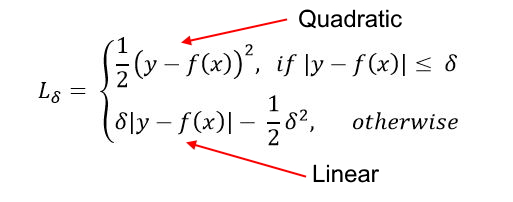

Huber loss combines the best properties of MSE and MAE. It is quadratic for smaller errors and is linear otherwise, based on delta parameter.

<b>Requirement of feature scaling: Yes</b>

<b>Robust to outliers: Yes</b>

<b>Is multicollinearity an issue?: Yes</b>

<b>Advantages of Huber regression</b>:
1. Model coefficients easy to interpret
2. Suitable to use for datasets with linear relationships
3. Model can be regularized to prevent model overfitting
4. Model performance less impacted by outliers

<b>Disadvantages of Huber regression</b>:
1. Model may be too simplistic, which may not be able to capture complex relationships between variables

<b>Important hyperparameters for Huber regression</b>:
1. alpha: Squared L2 Regularization strength value between 0 and inf
2. epsilon (delta): Threshold that controls number of samples classified as outliers. The smaller the epsilon, the more robust the model is to outliers.

In [13]:
reg = HuberRegressor()
pipeline = Pipeline(steps=[])
pipeline.steps.append(['gaussian_transform',GaussianTransformer(X_sub.columns.tolist())])
pipeline.steps.append(('scaling',ScalingTransformer('Robust')))
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['regression__alpha'] = Real(0.001, 1, prior="log-uniform")
search_space['regression__epsilon'] = Real(1.01, 2, prior="log-uniform")
nested_cv(X_sub, y, pipeline, search_space)

Validation RMSE for fold 1: 0.7792251867790693
Best hyperparameters for fold 1: OrderedDict([('regression__alpha', 0.8242631493012178), ('regression__epsilon', 1.050261252849173)])
Test RMSE for fold 1: 0.7378937659016908
Validation RMSE for fold 2: 0.7764177772523492
Best hyperparameters for fold 2: OrderedDict([('regression__alpha', 0.6388932140278595), ('regression__epsilon', 1.0386665282486418)])
Test RMSE for fold 2: 0.7689618776523497
Validation RMSE for fold 3: 0.7740223234202434
Best hyperparameters for fold 3: OrderedDict([('regression__alpha', 0.5527999110629841), ('regression__epsilon', 1.012990597891719)])
Test RMSE for fold 3: 0.7896559552147002
Validation RMSE for fold 4: 0.774572337305845
Best hyperparameters for fold 4: OrderedDict([('regression__alpha', 0.048731877989933746), ('regression__epsilon', 1.1517440993839823)])
Test RMSE for fold 4: 0.7661485199094212
Validation RMSE for fold 5: 0.7775676030203335
Best hyperparameters for fold 5: OrderedDict([('regression__al

# Regularization

Regularization in regression models reduce model overfitting by adding shrinkage penalty to cost function.

There are three types of regularization models:

1. LASSO (Least Absolute Shrinkage & Selection Operator)

2. Ridge

3. ElasticNet

## Ridge Regression (l2 regularization)

Ridge regression is most commonly used for datasets that have <b>multicollinearity</b> or datasets where <b>number of features exceed number of observations</b>.

Cost function of Ridge regression (l2 penalty):

<img src ="https://www.analyticsvidhya.com/wp-content/uploads/2016/01/eq5-1.png" width="500">

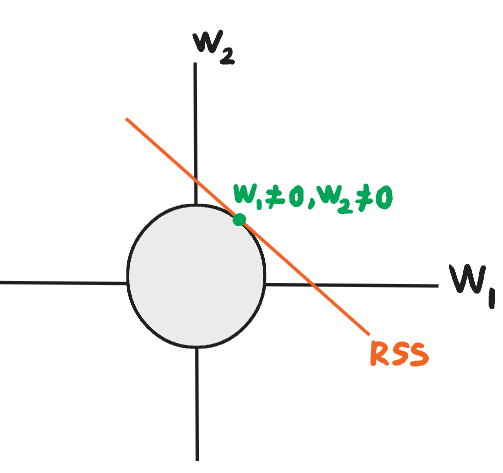

Ridge regression shrinks coefficients of features with little contribution but huge weights close to zero, but not exactly zero.

<b>Requirement of feature scaling: Yes</b>

<b>Robust to outliers: No</b>

<b>Is multicollinearity an issue?: No</b>

<b>Advantages of Ridge regression</b>:
1. Reduces risk of overfitting
2. Performs well for datasets where number of predictors larger than number of observations or datasets have multicollinearity.
3. Reduces model complexity

<b>Disadvantages of Ridge regression</b>:
1. Not capable of performing feature selection
2. Trades variance for bias, where coefficients do not represent the true magnitude of the relationship between features and target variable.
3. Model performance may be impacted by outliers

<b>Important hyperparameters for Ridge regression</b>:
1. alpha (lambda): Regularization strength value between 0 and inf (0 value indicates linear regression, which is not preferable)

In [14]:
reg = Ridge(random_state=120)
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X.columns.tolist())])
pipeline.steps.append(['gaussian_transform',GaussianTransformer(X.columns.tolist())])
pipeline.steps.append(('scaling',ScalingTransformer('Robust')))
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['regression__alpha'] = Real(0.001, 2, prior="log-uniform")
nested_cv(X, y, pipeline, search_space)

Validation RMSE for fold 1: 0.7426461850529643
Best hyperparameters for fold 1: OrderedDict([('regression__alpha', 0.0028160392972590305)])
Test RMSE for fold 1: 0.6653866422925819
Validation RMSE for fold 2: 0.7442456177156991
Best hyperparameters for fold 2: OrderedDict([('regression__alpha', 0.00245075981763087)])
Test RMSE for fold 2: 0.6754439434526152
Validation RMSE for fold 3: 0.7370558317283635
Best hyperparameters for fold 3: OrderedDict([('regression__alpha', 0.0011439026635881706)])
Test RMSE for fold 3: 0.708451375206896
Validation RMSE for fold 4: 0.7405550590941415
Best hyperparameters for fold 4: OrderedDict([('regression__alpha', 0.002260693741064997)])
Test RMSE for fold 4: 0.6971413377515253
Validation RMSE for fold 5: 0.7434034809321945
Best hyperparameters for fold 5: OrderedDict([('regression__alpha', 0.0014225259650810203)])
Test RMSE for fold 5: 0.6857238691380557
Validation RMSE for fold 6: 0.7427544764234055
Best hyperparameters for fold 6: OrderedDict([('regr

## Lasso Regression (l1 regularization)

Lasso regression is mostly used for quick feature selection.

Cost function of LASSO regression (l1 penalty):

<img src = "https://www.analyticsvidhya.com/wp-content/uploads/2016/01/eq8-1.png" width="500">

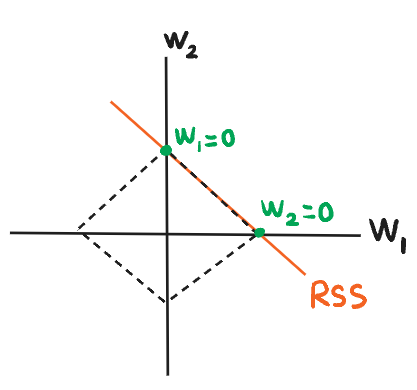

Lambda value controls bias-variance tradeoff to prevent model overfitting/underfitting.

For large values of lambda (tuning parameter), Lasso regression shrinks coefficients of features to exactly zero, which is suitable for feature selection.

<b>Requirement of feature scaling: Yes</b>

<b>Robust to outliers: No</b>

<b>Is multicollinearity an issue?: Yes</b>

<b>Advantages of Lasso regression</b>:
1. Reduces risk of overfitting
2. Performs feature selection by reducing coefficients of irrelevant features to zero

<b>Disadvantages of Lasso regression</b>:
1. Trades variance for bias, where coefficients do not represent the true magnitude of the relationship between features and target variable.
2. Doesn't perform well for datasets with multicollinearity
3. Model performance may be impacted by outliers

<b>Important hyperparameters for Lasso regression</b>:
1. alpha (lambda): Regularization strength value between 0 and inf (0 value indicates linear regression, which is not preferable)

In [15]:
reg = Lasso(random_state=120)
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X_sub.columns.tolist())])
pipeline.steps.append(['gaussian_transform',GaussianTransformer(X_sub.columns.tolist())])
pipeline.steps.append(('scaling',ScalingTransformer('Robust')))
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['regression__alpha'] = Real(0.001, 2, prior="log-uniform")
nested_cv(X_sub, y, pipeline, search_space)

Validation RMSE for fold 1: 1.1724088645772988
Best hyperparameters for fold 1: OrderedDict([('regression__alpha', 1.4869167200292979)])
Test RMSE for fold 1: 1.130076806027238
Validation RMSE for fold 2: 1.1657807070125803
Best hyperparameters for fold 2: OrderedDict([('regression__alpha', 1.367730723527613)])
Test RMSE for fold 2: 1.174779730823507
Validation RMSE for fold 3: 1.1673828939152309
Best hyperparameters for fold 3: OrderedDict([('regression__alpha', 1.4070829218309275)])
Test RMSE for fold 3: 1.1750060398784055
Validation RMSE for fold 4: 1.1668491837091948
Best hyperparameters for fold 4: OrderedDict([('regression__alpha', 1.4065464574926074)])
Test RMSE for fold 4: 1.1750794595254204
Validation RMSE for fold 5: 1.1681150931131077
Best hyperparameters for fold 5: OrderedDict([('regression__alpha', 0.7097963416071565)])
Test RMSE for fold 5: 1.163502662756397
Validation RMSE for fold 6: 1.1704418656284505
Best hyperparameters for fold 6: OrderedDict([('regression__alpha',

## ElasticNet Regression

ElasticNet regression is used to perform feature selection and regularization simultaneously. It is most suitable when the dataset has number of features higher than number of observations or dataset has multicollinearity.

Cost function of ElasticNet regression (Mixture between l1 and l2 penalty):

<img src ="https://miro.medium.com/max/1400/1*lmQmZR8RasogGb_rKCQV-w.png" width="500">

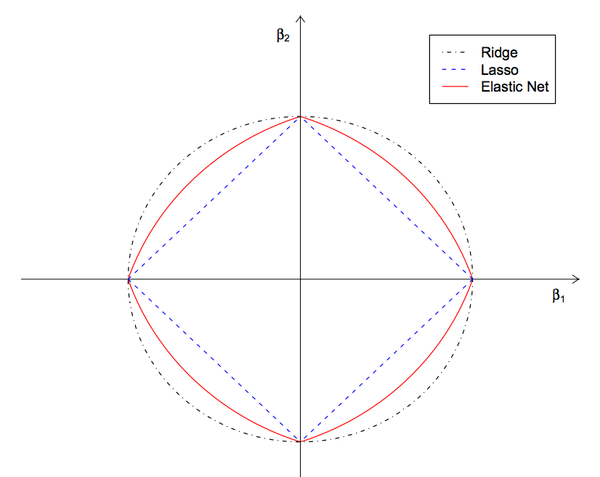

<b>Requirement of feature scaling: Yes</b>

<b>Robust to outliers: No</b>

<b>Is multicollinearity an issue?: No</b>

<b>Advantages of ElasticNet regression</b>:
1. Reduces risk of overfitting
2. Performs well for datasets that have multicollinearity.

<b>Disadvantages of ElasticNet regression</b>:
1. Trades variance for bias, where coefficients do not represent the true magnitude of the relationship between features and target variable.
2. Model performance may be impacted by outliers
3. Higher time complexity than Ridge and Lasso regression

<b>Important hyperparameters for Lasso regression</b>:
1. alpha (lambda1): Regularization strength value between 0 and inf (0 value indicates linear regression, which is not preferable)
2. l1 ratio (lambda1 / (lambda1 + lambda2)):  ElasticNet mixing parameter between 0 and 1 (0 indicates Ridge regression, while 1 indicates Lasso regression)

In [16]:
reg = ElasticNet(random_state=120)
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X.columns.tolist())])
pipeline.steps.append(['gaussian_transform',GaussianTransformer(X.columns.tolist())])
pipeline.steps.append(('scaling',ScalingTransformer('Robust')))
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['regression__alpha'] = Real(0.001, 2, prior="log-uniform")
search_space['regression__l1_ratio'] = Real(0.000001,0.999999, prior="log-uniform")
nested_cv(X, y, pipeline, search_space)

Validation RMSE for fold 1: 0.938276139694827
Best hyperparameters for fold 1: OrderedDict([('regression__alpha', 0.8236576501109807), ('regression__l1_ratio', 0.0003424897456336443)])
Test RMSE for fold 1: 0.8773037577924604
Validation RMSE for fold 2: 0.9733620237629836
Best hyperparameters for fold 2: OrderedDict([('regression__alpha', 1.2269943253617865), ('regression__l1_ratio', 7.230891502409266e-06)])
Test RMSE for fold 2: 0.95769266969591
Validation RMSE for fold 3: 0.8579243428209073
Best hyperparameters for fold 3: OrderedDict([('regression__alpha', 0.385364544011862), ('regression__l1_ratio', 0.010405881396586322)])
Test RMSE for fold 3: 0.842530538932759
Validation RMSE for fold 4: 1.0782915483536883
Best hyperparameters for fold 4: OrderedDict([('regression__alpha', 1.0034428973073626), ('regression__l1_ratio', 0.3817928684020458)])
Test RMSE for fold 4: 1.0799372544189256
Validation RMSE for fold 5: 0.9881056269927198
Best hyperparameters for fold 5: OrderedDict([('regres